In [1]:
import numpy as np
import pandas as pd
# 1. Генерация данных
# Имитационная модель объекта
def eta(x):
  eta_vec = np.empty(len(x))
  for i in range(len(x)):
    eta_vec[i] = np.sum(x[i,:])
  return eta_vec

# Генерация плана эксперимента
def generate_X():
    X = []
    for x1 in np.linspace(-1, 1, 5):
      for x3 in np.linspace(-2, 2, 10): 
        for x5 in np.linspace(-0.5, 0.5, 5):
          for x6 in np.linspace(-1, 1, 5):
            for x7 in np.linspace(-3, 3, 15):
              for x8 in np.linspace(-1, 1, 5):
                e = []
                for i in range(2):
                  np.random.seed(i)
                  e.append(np.random.normal(loc=0, scale=0.001))
                X.append([1, x1, x1 + e[0], x3, x3 + e[1], x5, x6, x7, x8])
    return np.matrix(X)

# Зашумление данных
def noise_data(u):
    y = np.copy(u)
    np.random.seed(0)
    for j in range(len(u)):
        ej = np.random.normal(loc=0, scale=(0.1*np.average(u))**(1/2))
        y[j] += ej
    return y

X = generate_X()
u = eta(X)
y = noise_data(u)

In [2]:
# 2. Показатели, характеризующие эффект мультиколлинеарности
# 2.1. Определитель информационной матрицы
det = np.linalg.det(X.T*X)
print("Определитель информационной матрицы =", '{:.4e}'.format(det))
# 2.2. Минимальное собственное число информационной матрицы
X_eig, _ = np.linalg.eig(X.T*X)
min_l1 = min(X_eig)
print("Минимальное собственное число информационной матрицы =", '{:.4e}'.format(min_l1))
# 2.3. Мера обусловленности матрицы по Нейману-Голдстейну
m = max(X_eig) / min(X_eig)
print("Мера обусловленности матрицы по Нейману-Голдстейну =", '{:.4e}'.format(m))

Определитель информационной матрицы = 1.4369e+14
Минимальное собственное число информационной матрицы = 5.0149e-11
Мера обусловленности матрицы по Нейману-Голдстейну = 6.4095e+15


In [3]:
# 2.4. Максимальная парная сопряженность
R = np.empty((9, 9))
for i in range(9):
  for j in range(9):
    if i == j: 
      R[i][j] = -1
    else: 
      #R[i][j] = cosine(X[i,:], X[j,:])
      u, v = np.squeeze(np.asarray(X[i,:])), np.squeeze(np.asarray(X[j,:]))
      R[i][j] = np.dot(u, v) / (np.sum(u**2)**(1/2) * np.sum(v**2)**(1/2))
maxr = np.max(R)
print("Максимальная парная сопряженность =", '{:.4e}'.format(maxr))
for i in range(9):
  for j in range(9):
    if i == j: R[i][j] = 1

# Максимальная сопряженность
invR = np.linalg.inv(R)
diag = np.diag(invR)
R_vec = np.sqrt(1 - 1 / diag)
maxsopr = np.max(R_vec)
print("Максимальная сопряженность =", '{:.4e}'.format(maxsopr))

Максимальная парная сопряженность = 9.9724e-01
Максимальная сопряженность = 1.0000e+00


In [4]:
# 3. Ридж - оценки
def calc_theta(X, y, l):
  XT_X = X.T*X
  L = np.diag(l * np.diag(XT_X))
  return np.array(np.dot(np.linalg.inv(XT_X + L)*X.T, y))[0]

def calc_RSS(X, y, theta):
  a = np.array(y - np.dot(X, theta))[0]
  return np.sum(a ** 2)

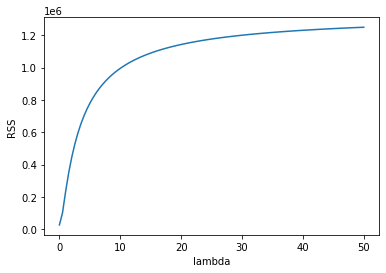

In [5]:
import matplotlib.pyplot as plt
l = np.linspace(0, 50, 100)
# RSS
rss_s = [calc_RSS(X, y, calc_theta(X, y, l_cur)) for l_cur in l]
ax = plt.axes()
ax.set_xlabel("lambda")
ax.set_ylabel("RSS")
ax.plot(l, rss_s)

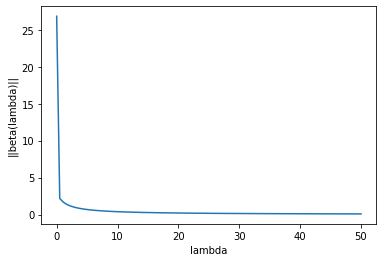

In [6]:
# beta
ax1 = plt.axes()
ax1.set_xlabel("lambda")
ax1.set_ylabel("||beta(lambda)||")
beta_s = [(np.sum(calc_theta(X, y, l_cur)**2))**(1/2) for l_cur in l]
ax1.plot(l, beta_s)

In [7]:
l_new = np.linspace(0, 50, 10000)
diffs = []
for l_cur in l_new:
  true_vals = np.linalg.norm(np.ones(9))
  theta = calc_theta(X, y, l_cur)
  cur_vals = np.linalg.norm(theta)
  diff = abs(true_vals - cur_vals)
  diffs.append(diff)
index_min = np.argmin(diffs)
index_max = np.argmax(diffs)
l_test = l_new[index_min]
print("theta =", calc_theta(X, y, l_test))
print("l =", '{:.4e}'.format(l_test))

theta = [0.99514965 0.99714346 1.00064822 0.99699689 0.9979872  1.00009141
 0.99392694 0.99452825 0.99688335]
l = 5.0005e-03


In [8]:
diff = (np.sum((np.ones(9) - calc_theta(X, y, l_test))**2))**(1/2)
print("||theta = theta*|| =", '{:.4e}'.format(diff))

||theta = theta*|| = 1.1033e-02


In [9]:
l_best = 20
print("Наилучшее lambda =", '{:.4e}'.format(l_best))
print("RSS =", '{:.4e}'.format(rss_s[-1]))
print("|beta| =", '{:.4e}'.format(beta_s[-1]))

Наилучшее lambda = 2.0000e+01
RSS = 1.2491e+06
|beta| = 8.8662e-02


In [10]:
best_theta = calc_theta(X, y, l_best)
np.set_printoptions(precision=4)
print("theta* =", best_theta)

theta* = [0.0478 0.091  0.0912 0.0909 0.091  0.0479 0.0476 0.0476 0.0477]


In [11]:
diff = (np.sum((np.ones(9) - best_theta)**2))**(1/2)
print("||theta = theta*|| =", '{:.4e}'.format(diff))

||theta = theta*|| = 2.7999e+00


In [12]:
# 4. Метод главных компонент
# 4.1. Центрирование переменных
y_c = y - np.average(y)
X_c = X.copy()
for i in range(9):
  X_c[1:,i] -= np.average(X_c[1:,i])
# 4.2. Найдем собственные значения и собственные векторы
X_c_eig_vals, V = np.linalg.eig(X_c.T*X_c)
print("Собственные значения:", X_c_eig_vals)
X_eig_importances = X_c_eig_vals / np.sum(X_c_eig_vals)
print("Вклады собственных значений:", X_eig_importances)
Z = X_c * V

Собственные значения: [ 3.2143e+05  3.0556e+05  9.3750e+04  1.1719e+04  9.9986e-01  4.6875e+04
  4.6875e+04 -2.9565e-11  6.9948e-12]
Вклады собственных значений: [ 3.8904e-01  3.6983e-01  1.1347e-01  1.4184e-02  1.2102e-06  5.6735e-02
  5.6735e-02 -3.5785e-17  8.4662e-18]


In [13]:
to_del = []
for i in range(len(X_eig_importances)):
  if X_eig_importances[i] < 1e-2:
    to_del.append(i) 
to_del

[4, 7, 8]

In [14]:
Z_new = np.delete(Z, to_del, 1)
V_new = np.delete(V, to_del, 1)
print("Собственные значения с незначительным вкладом:", X_c_eig_vals[to_del])

Собственные значения с незначительным вкладом: [ 9.9986e-01 -2.9565e-11  6.9948e-12]


In [15]:
b = np.dot(np.linalg.inv(Z_new.T*Z_new)*Z_new.T, y_c)
theta_pca = np.squeeze(np.asarray(np.dot(V_new, b.T)))
print("theta* =", theta_pca)

theta* = [-1.2933e-04  1.0014e+00  1.0014e+00  9.9998e-01  9.9998e-01  1.0051e+00
  9.9890e-01  9.9950e-01  1.0019e+00]


In [16]:
diff_pca = (np.sum((theta_pca - np.ones(9))**2))**(1/2)
print("||theta - theta*|| =", '{:.4e}'.format(diff_pca))

||theta - theta*|| = 1.0001e+00
